## Toxic classification using Bidirectional LSTM (Bidirectional RNN)

### Pre-requisites

- Download the data: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Download the word vectors: http://nlp.stanford.edu/data/glove.6B.zip

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
np.random.seed(4)
random.seed(7)

In [3]:
# Configurations
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

#### Load pre-trained word vectors

In [4]:
print('Loading word vectors....')
word2vec = {}

with open(os.path.join('Embeddings/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
     # The file contains just a space-separated text file in the format:
     # word vec[0] vec[1] vec[2] ...
    for line in f:
        # splits at spaces
        values = line.split()
        word = values[0]
        #np.asarray Converts the input to an array.
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))
print('Embedding dimensions: ', word2vec['the'].shape)

Loading word vectors....
Found 400000 word vectors.
Embedding dimensions:  (100,)


### Prepare training data

In [5]:
print('Loading comments')

train = pd.read_csv('data/toxic_comment/train.csv', header = 0)
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#possible_labels = train.columns.values[2:]
targets = train[possible_labels].values
print('Number of training examples in training set:' , train.shape[0])
print('Training set shape:', train.shape)
print('Training set targets shape:', targets.shape)
train.head(10)

Loading comments
Number of training examples in training set: 159571
Training set shape: (159571, 8)
Training set targets shape: (159571, 6)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


394.0732213246768 590.7202819048919 5000


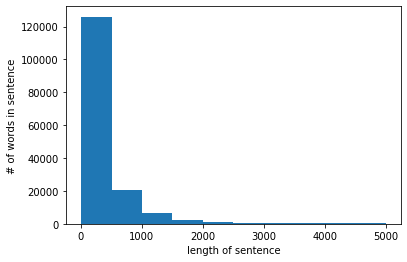

In [6]:
# The length of the comments varies a lot.
lengths = train.comment_text.str.len()
print(lengths.mean(), lengths.std(), lengths.max())
plt.hist(lengths)
plt.xlabel('length of sentence')
plt.ylabel('# of words in sentence')
plt.show()

### Convert the sentences (string) into integers

In [7]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
#print('sequences:', sequences); exit()

In [8]:
print('Sentence: %s \n' % sentences[0:1])
print('Sentence in a sequence form: %s \n' % sequences[0:1])

print('Max sequence length:', max(len(s) for s in sequences))
print('Min sequence length:', min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print('median sequence length:', s[len(s)//2])

Sentence: ["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"] 

Sentence in a sequence form: [[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]] 

Max sequence length: 1400
Min sequence length: 0
median sequence length: 35


### Word to integer mapping

In [9]:
word2idx = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word2idx)))

punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for w in ''.join(sentences[0:1]).split():         
    if w.lower() in word2idx:
       print('{} --> {}'.format(w, word2idx[w.lower()]))
    else:
        print('{} --> {}'.format(w, 'NA'))

Found 210337 unique tokens.
Explanation --> 688
Why --> 75
the --> 1
edits --> 126
made --> 130
under --> 177
my --> 29
username --> 672
Hardcore --> 4511
Metallica --> 12052
Fan --> 1116
were --> 86
reverted? --> NA
They --> 51
weren't --> 2278
vandalisms, --> NA
just --> 50
closure --> 6864
on --> 15
some --> 60
GAs --> 2756
after --> 148
I --> 7
voted --> 2937
at --> 34
New --> 117
York --> 1221
Dolls --> 15190
FAC. --> NA
And --> 4
please --> 45
don't --> 59
remove --> 244
the --> 1
template --> 365
from --> 31
the --> 1
talk --> 38
page --> 27
since --> 143
I'm --> 73
retired --> 3462
now.89.205.38.27 --> NA


### Pad Sequences

In [10]:
# pad sequences so that we get a N x T matrix where N is number of samples (examples) and T is sequence length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data:', data.shape)

Shape of data: (159571, 100)


### Prepare Embedding matrix

In [11]:
print('Filling Pre-trained embeddings')
num_words = min(MAX_VOCAB_SIZE, len(word2vec)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will all be zero
            embedding_matrix[i] = embedding_vector

# 20000 words each of 100 dimensions
print('Shape of Embeddings matrix: ', embedding_matrix.shape)

Filling Pre-trained embeddings
Shape of Embeddings matrix:  (20000, 100)


### Embedding layer

In [12]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

W0915 21:58:26.872684 139766846879104 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



### Build Bi-directional LSTM model

In [13]:
print('Building model:')

# Create an LSTM network with a single LSTM.
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)

output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer = Adam(lr=0.01), metrics=['acc'])
model.summary()

W0915 21:58:26.913212 139766846879104 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 21:58:26.919147 139766846879104 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 21:58:26.929490 139766846879104 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0915 21:58:26.930161 139766846879104 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf

Building model:


W0915 21:58:32.702655 139766846879104 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 21:58:32.713374 139766846879104 deprecation.py:323] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 2,014,106
Trainable params: 14,106
Non-trainable params: 2,000,000
_________________________________________________________________


### Training Model

In [14]:
history = model.fit(data, targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 387s 3ms/step - loss: 0.0697 - acc: 0.9767 - val_loss: 0.0564 - val_acc: 0.9799
Epoch 2/10
127656/127656 [==============================] - 383s 3ms/step - loss: 0.0524 - acc: 0.9811 - val_loss: 0.0538 - val_acc: 0.9803
Epoch 3/10
127656/127656 [==============================] - 381s 3ms/step - loss: 0.0503 - acc: 0.9816 - val_loss: 0.0533 - val_acc: 0.9803
Epoch 4/10
127656/127656 [==============================] - 381s 3ms/step - loss: 0.0487 - acc: 0.9821 - val_loss: 0.0519 - val_acc: 0.9812
Epoch 5/10
127656/127656 [==============================] - 382s 3ms/step - loss: 0.0478 - acc: 0.9824 - val_loss: 0.0513 - val_acc: 0.9812
Epoch 6/10
127656/127656 [==============================] - 383s 3ms/step - loss: 0.0474 - acc: 0.9823 - val_loss: 0.0512 - val_acc: 0.9811
Epoch 7/10
127656/127656 [==============================] - 384s 3ms/step - loss: 0.0463 - acc: 0.9828 - val_

### Visualize accuracy and loss curves

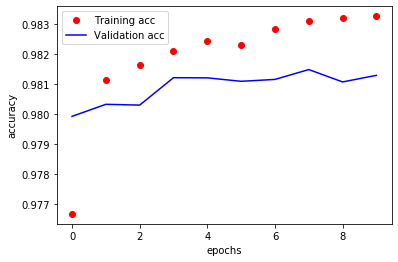

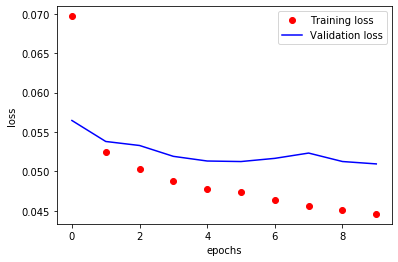

<Figure size 432x288 with 0 Axes>

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('static/acc_toxic_bilstm.png')
plt.show()
plt.clf()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('static/loss_toxic_bilstm.png')
plt.show()
plt.clf()

In [16]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

0.9847794013738967
